In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
init_lr = 1e-4 #initial learning rate
epochs = 20 #no of training epochs(the no of times the model will pass through the entire dataset
bs = 32 #batch size(no of images processed at once)

In [5]:
directory = r"C:\Users\akila\OneDrive\Desktop\My learnings\Projects\Face Mask Detection\images"
categories = ["with_mask", "without_mask"]

In [7]:
print("[INFO] loading images.....") 

data=[]
labels=[]

for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):#img as in 1.jpg, 2.jpg.....
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
        
print("completed")

[INFO] loading images.....
completed


In [8]:
lb= LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)


In [9]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [10]:
baseModel = MobileNetV2(weights = "imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

C:\Users\akila\AppData\Local\Temp\ipykernel_29308\2501471180.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights = "imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [16]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
for layer in baseModel.layers:
	layer.trainable = False


In [18]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("done")


[INFO] compiling model...
done


In [23]:
print("[INFO] training head...")
validation_steps = max(1, len(testX) // bs)

H = model.fit(
    aug.flow(trainX, trainY, batch_size=bs),  # Training data as a generator
    steps_per_epoch=max(1, len(trainX) // bs),
    validation_data=ImageDataGenerator().flow(testX, testY, batch_size=bs),  # Use generator
    validation_steps=validation_steps,
    epochs=epochs
)
print("completed")

[INFO] training head...
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 870ms/step - accuracy: 0.9704 - loss: 0.1054 - val_accuracy: 0.9891 - val_loss: 0.0550
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0467 - val_accuracy: 1.0000 - val_loss: 0.0371
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 85s 863ms/step - accuracy: 0.9808 - loss: 0.0765 - val_accuracy: 0.9891 - val_loss: 0.0481
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9688 - loss: 0.0999 - val_accuracy: 1.0000 - val_loss: 0.0307
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 887ms/step - accuracy: 0.9795 - loss: 0.0637 - val_accuracy: 0.9905 - val_loss: 0.0427
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0341
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 957ms/step - accuracy: 0.9803 - loss: 0.0597 - val_accuracy: 0.9891 - val_loss: 0.0399
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 1.0000 - loss: 0

In [25]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=bs)


[INFO] evaluating network...
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step


In [26]:
predIdxs = np.argmax(predIdxs, axis=1)


In [27]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [29]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")

[INFO] saving mask detector model...


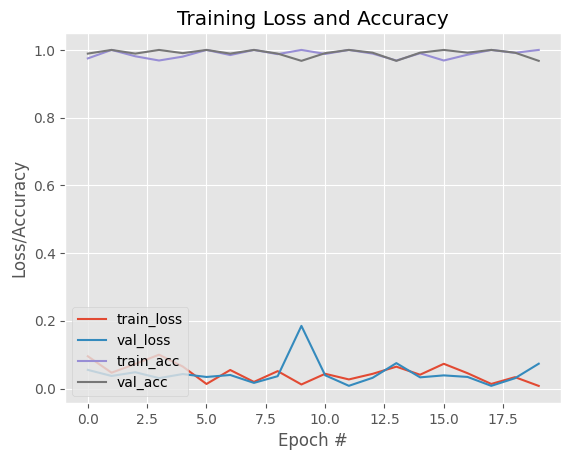

In [31]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")